In [1]:
import os
import glob
import re
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from collections import deque

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
#############################################
# 1. 유틸리티 함수들
#############################################

def get_orig_and_norm_Da(domain_num):
    if 1 <= domain_num <= 2000:
        orig_Da = 0.5
    elif 2001 <= domain_num <= 4000:
        orig_Da = 2.0
    elif 4001 <= domain_num <= 6000:
        orig_Da = 5.0
    else:
        raise ValueError(f"Domain number {domain_num} out of expected range")
    norm_Da = (orig_Da - 0.5) / 4.5
    return orig_Da, norm_Da

def create_distance_map_from_pivots(grid, start_range=(28,36)):
    if grid is None or grid.size == 0:
        return np.array([])
    rows, cols = grid.shape
    sr, er = start_range
    starts = [(i, 0) for i in range(sr, er)]
    valid = [pt for pt in starts if grid[pt] == 1]
    dist = np.full((rows, cols), -1, dtype=np.int32)
    if not valid:
        return dist
    queue = deque([(pt, 0) for pt in valid])
    visited = set(valid)
    dirs = [(-1,0),(0,1),(1,0),(0,-1)]
    while queue:
        (r, c), d = queue.popleft()
        if dist[r,c] < 0 or d < dist[r,c]:
            dist[r,c] = d
        for dr, dc in dirs:
            nr, nc = r+dr, c+dc
            if 0 <= nr < rows and 0 <= nc < cols and (nr,nc) not in visited and grid[nr,nc] == 1:
                visited.add((nr,nc))
                queue.append(((nr,nc), d+1))
    return dist

In [3]:
def load_concentration_data(npz_dir):
    m_files = sorted(
        glob.glob(os.path.join(npz_dir, "m*.npz")),
        key=lambda x: int(re.search(r"m(\d+)\.npz", os.path.basename(x)).group(1)))
    domains = []
    for m_file in m_files:
        dnum = int(re.search(r"m(\d+)\.npz", os.path.basename(m_file)).group(1))
        A_file = os.path.join(npz_dir, f"A{dnum}.npz")
        if not os.path.exists(A_file):
            continue
        with np.load(m_file) as d:
            m_raw = d['m'].reshape((64,148))
            m = (m_raw > 0.5).astype(np.int32)   # <--- 이진화!
        with np.load(A_file) as d:
            A_flat = d['A']  # (T,64*148)
            T = A_flat.shape[0]
            A = A_flat.reshape((T,64,148))
        domains.append({'domain_num':dnum, 'm':m, 'A':A})
    return domains

def process_concentration_domain(domain_data, nx=64, ny=148, pivot_range=(28,36), t_primes=None):
    if t_primes is None:
        t_primes = [0.0, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 0.28, 0.32, 0.36]

    dnum = domain_data['domain_num']
    m = domain_data['m']
    A_series = domain_data['A']
    _, Da_norm = get_orig_and_norm_Da(dnum)

    branch1_input = m.reshape((1, nx, ny))
    branch2_input = np.array([Da_norm], dtype=np.float32)

    # SDF 생성 (공극만 거리, 암석=0, 공극 min/max 정규화)
    sdf = create_distance_map_from_pivots(m, start_range=pivot_range).astype(np.float32)
    sdf[sdf < 0] = 0
    if np.any(m > 0):
        sdf_min, sdf_max = sdf[m > 0].min(), sdf[m > 0].max()
        sdf_norm = np.zeros_like(sdf)
        sdf_norm[m > 0] = (sdf[m > 0] - sdf_min) / (sdf_max - sdf_min + 1e-8)
    else:
        sdf_norm = np.zeros_like(sdf)
    sdf_norm[m == 0] = 0

    x = np.arange(nx, dtype=np.float32)
    y = np.arange(ny, dtype=np.float32)
    X, Y = np.meshgrid(x, y, indexing='ij')
    x_flat, y_flat = X.flatten(), Y.flatten()
    sdf_flat = sdf_norm.flatten()

    branch1_list, branch2_list, trunk_list, target_list = [], [], [], []
    T = A_series.shape[0]

    for t_prime in t_primes:
        k = int(round(t_prime * (T - 1)))
        k = max(0, min(k, T-1))
        A_t = A_series[k].astype(np.float32)
        t_chan = np.full((nx*ny,), t_prime, dtype=np.float32)
        trunk_q = np.stack([x_flat, y_flat, sdf_flat, t_chan], axis=1)
        branch1_list.append(branch1_input)
        branch2_list.append(branch2_input)
        trunk_list.append(trunk_q)
        target_list.append(A_t[..., np.newaxis])
    return branch1_list, branch2_list, trunk_list, target_list

def build_concentration_dataset(domains, nx=64, ny=148, pivot_range=(28,36), t_primes=None):
    b1_all, b2_all, t_all, tgt_all = [], [], [], []
    for d in domains:
        b1, b2, t, tgt = process_concentration_domain(d, nx, ny, pivot_range, t_primes)
        b1_all.extend(b1)
        b2_all.extend(b2)
        t_all.extend(t)
        tgt_all.extend(tgt)
    b1_arr = np.stack(b1_all, axis=0)
    b2_arr = np.stack(b2_all, axis=0)
    t_arr  = np.stack(t_all, axis=0)
    tgt_arr = np.stack(tgt_all, axis=0)
    b1_tensor = torch.tensor(b1_arr, dtype=torch.float32)
    b2_tensor = torch.tensor(b2_arr, dtype=torch.float32)
    t_tensor  = torch.tensor(t_arr, dtype=torch.float32)
    tgt_tensor = torch.tensor(tgt_arr, dtype=torch.float32)
    return b1_tensor, b2_tensor, t_tensor, tgt_tensor

In [4]:
#############################################
# 3. 데이터 분할 및 텐서화
#############################################
npz_dir = "/home/yehoon/npz/amv/Fo_10/Fo_10t"
all_domains = load_concentration_data(npz_dir)

g1 = [d for d in all_domains if 1<=d['domain_num']<=2000]
g2 = [d for d in all_domains if 2001<=d['domain_num']<=4000]
g3 = [d for d in all_domains if 4001<=d['domain_num']<=6000]

random.seed(42)
def split(g, n): random.shuffle(g); return g[:n], g[n:]
tr1, te1 = split(g1,1800)
tr2, te2 = split(g2,1800)
tr3, te3 = split(g3,1800)
train_domains = tr1+tr2+tr3
test_domains  = te1+te2+te3

# 데이터셋 생성
train_b1, train_b2, train_trunk, train_tgt = build_concentration_dataset(train_domains)
test_b1, test_b2, test_trunk, test_tgt = build_concentration_dataset(test_domains)

train_ds = TensorDataset(train_b1, train_b2, train_trunk, train_tgt)
test_ds  = TensorDataset(test_b1, test_b2, test_trunk, test_tgt)

In [5]:
class BasicCNN(nn.Module):
    def __init__(self, in_ch, out_dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch,16,3,1,1), nn.SiLU(), nn.AvgPool2d(2),
            nn.Conv2d(16,32,3,1,1), nn.SiLU(), nn.AvgPool2d(2),
            nn.Conv2d(32,64,3,1,1), nn.SiLU(), nn.AvgPool2d(2)
        )
        self.fc = nn.Linear(64*9*16, out_dim)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class BasicMLP(nn.Module):
    def __init__(self, in_dim, out_dim, num_layers=2, width=64):
        super().__init__()
        layers = [nn.Linear(in_dim, width), nn.SiLU()]
        for _ in range(num_layers-2):
            layers += [nn.Linear(width, width), nn.SiLU()]
        layers += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class ConcentrationDeepONet2Branch(nn.Module):
    def __init__(self, branch1_in=1, branch2_in=1, trunk_in=4, out_dim=80,
                 branch2_width=32, trunk_layers=4, trunk_width=80,
                 nx=64, ny=148):
        super().__init__()
        self.branch1 = BasicCNN(branch1_in, out_dim)
        self.branch2 = BasicMLP(branch2_in, out_dim, num_layers=2, width=branch2_width)
        trunk_layers = max(trunk_layers, 2)
        layers = [nn.Linear(trunk_in, trunk_width), nn.SiLU()]
        for _ in range(trunk_layers-2):
            layers += [nn.Linear(trunk_width, trunk_width), nn.SiLU()]
        layers += [nn.Linear(trunk_width, out_dim)]
        self.trunk = nn.Sequential(*layers)
        self.bias = nn.Parameter(torch.zeros(1))
        self.nx, self.ny = nx, ny
    def forward(self, b1, b2, t):
        N, L, _ = t.shape
        b1_out = self.branch1(b1).unsqueeze(1)    # (N,1,q)
        b2_out = self.branch2(b2).unsqueeze(1)    # (N,1,q)
        trunk_out = self.trunk(t.view(-1, t.shape[-1])).view(N, L, -1)  # (N,L,q)
        # elementwise multiply & sum over q
        fused = b1_out * b2_out * trunk_out       # (N,L,q)
        out = fused.sum(-1) + self.bias           # (N,L)
        return out.view(N, self.nx, self.ny, 1)


In [6]:
def train_model(model, train_ds, test_ds, num_epochs=1000, lr=0.001, batch_size=25, patience=15):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.HuberLoss(delta=1.0)
    scaler = torch.cuda.amp.GradScaler()

    class EarlyStopping:
        def __init__(self, patience=10, delta=1e-5, verbose=False):
            self.patience = patience
            self.delta = delta
            self.verbose = verbose
            self.counter = 0
            self.best_loss = None
            self.early_stop = False
            self.best_model_state = None
        def __call__(self, val_loss, model):
            if self.best_loss is None or val_loss < self.best_loss - self.delta:
                self.best_loss = val_loss
                self.counter = 0
                self.best_model_state = copy.deepcopy(model.state_dict())
                if self.verbose:
                    print(f"Validation loss decreased. New best loss: {val_loss:.6f}")
            else:
                self.counter += 1
                if self.verbose:
                    print(f"No improvement in validation loss. Counter: {self.counter}/{self.patience}")
                if self.counter >= self.patience:
                    self.early_stop = True
    early_stopping = EarlyStopping(patience=patience, delta=1e-5, verbose=True)
    train_losses, test_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for b1, b2, t, tgt in train_loader:
            b1, b2, t, tgt = b1.to(device), b2.to(device), t.to(device), tgt.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                preds = model(b1, b2, t)
                loss = criterion(preds, tgt)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_train_loss += loss.item()
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for b1, b2, t, tgt in test_loader:
                b1, b2, t, tgt = b1.to(device), b2.to(device), t.to(device), tgt.to(device)
                with torch.cuda.amp.autocast():
                    preds = model(b1, b2, t)
                    loss = criterion(preds, tgt)
                running_test_loss += loss.item()
        avg_test_loss = running_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")
        early_stopping(avg_test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered. Restoring best model state.")
            model.load_state_dict(early_stopping.best_model_state)
            break
    return train_losses, test_losses

def evaluate_model(model, test_ds, batch_size=25):
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    criterion = nn.HuberLoss(delta=1.0)
    total_loss = 0
    with torch.no_grad():
        for b1, b2, t, tgt in test_loader:
            b1, b2, t, tgt = b1.to(device), b2.to(device), t.to(device), tgt.to(device)
            preds = model(b1, b2, t)
            loss = criterion(preds, tgt)
            total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    print("Average Test Loss:", avg_loss)
    return avg_loss


In [7]:
#############################################
# 6. 후보정 및 후보정 기반 시각화 함수들 (농도)
#############################################
def apply_candidate_correction(field, mask):
    """
    field: 예측 또는 실제 필드, shape = (nx, ny, channels)
    mask: 초기 도메인 이미지, shape = (nx, ny) (광물 위치가 0으로 표시되어 있다고 가정)
    반환: 후보정된 field (광물 위치는 0)
    """
    corrected = field.copy()
    mineral_mask = (mask == 0)
    if corrected.ndim == 3:
        mineral_mask_3d = np.repeat(mineral_mask[:, :, np.newaxis], corrected.shape[2], axis=2)
        corrected[mineral_mask_3d] = 0
    else:
        corrected[mineral_mask] = 0
    return corrected

def inverse_normalize(pred, norm_params):
    """
    pred: (nx, ny, 1) 정규화된 농도 예측값.
    norm_params: {'A_min': ..., 'A_max': ...}
    """
    epsilon = 1e-8
    pred_denorm = pred * (norm_params['A_max'] - norm_params['A_min'] + epsilon) + norm_params['A_min']
    return pred_denorm

def visualize_results_concentration_corrected(model, branch_tensor, trunk_tensor, target_tensor, norm_params, sample_idx, save_svg=None):
    """
    후보정된 농도 필드(예측/실제)를 시각화합니다.
    - branch_tensor의 첫 채널(mask)를 사용하여 후보정 적용.
    - 두 서브플롯(실제, 예측)이 동일한 색상 스케일을 사용하도록 하고, 공통 컬러바를 추가합니다.
    - save_svg가 지정되면 결과 그림을 SVG 파일로 저장합니다.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        sample_branch = branch_tensor[sample_idx:sample_idx+1].to(device)
        sample_trunk = trunk_tensor[sample_idx:sample_idx+1].to(device)
        preds = model(sample_branch, sample_trunk).cpu().numpy()[0]   # (nx, ny, 1)
        actual = target_tensor[sample_idx].cpu().numpy()               # (nx, ny, 1)
    preds_denorm = inverse_normalize(preds, norm_params)
    actual_denorm = inverse_normalize(actual, norm_params)
    
    # branch의 첫 채널을 mask로 사용하여 후보정 적용
    mask = branch_tensor[sample_idx].cpu().numpy()[0]
    preds_corr = apply_candidate_correction(preds_denorm, mask)
    actual_corr = apply_candidate_correction(actual_denorm, mask)
    
    # 두 이미지 모두에서 최소/최대를 계산하여 동일한 컬러 스케일로 설정
    vmin = min(actual_corr.min(), preds_corr.min())

    vmax = max(actual_corr.max(), preds_corr.max())
    
    # 서브플롯 생성 및 공통 컬러바 추가
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    im1 = ax1.imshow(actual_corr.squeeze(), cmap='viridis', vmin=vmin, vmax=vmax)
    ax1.set_title("Silmulation Conc")
    im2 = ax2.imshow(preds_corr.squeeze(), cmap='viridis', vmin=vmin, vmax=vmax)
    ax2.set_title("PRT_DeepoNet Conc")
    cbar = fig.colorbar(im2, ax=[ax1, ax2], orientation='vertical', shrink=0.4, fraction=0.046, pad=0.04)
    
    plt.suptitle(f"Sample {sample_idx}")
    if save_svg is not None:
        plt.savefig(save_svg, format='svg')
    plt.show()

def scatter_concentration_corrected(preds_denorm, actual_denorm, mask, save_svg=None):
    """
    후보정된 농도 결과를 이용하여 산점도를 그립니다.
    save_svg: 저장할 파일 경로를 지정하면 SVG로 저장.
    """
    preds_corr = apply_candidate_correction(preds_denorm, mask)
    actual_corr = apply_candidate_correction(actual_denorm, mask)
    plt.figure(figsize=(8,8))
    plt.scatter(actual_corr.flatten(), preds_corr.flatten(), alpha=0.5, label='Data points')
    min_val = min(actual_corr.min(), preds_corr.min())
    max_val = max(actual_corr.max(), preds_corr.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (1:1 line)')
    plt.xlabel("Actual Concentration")
    plt.ylabel("Predicted Concentration")
    plt.title("Scatter Plot: Predicted vs. Actual Concentration (Corrected)")
    plt.legend()
    if save_svg is not None:
        plt.savefig(save_svg, format='svg')
    plt.show()

def compute_mape_nrmse_concentration_corrected(preds_denorm, actual_denorm, mask, epsilon=1e-8):
    """
    후보정된 농도 결과를 이용하여 MAPE와 NRMSE를 계산합니다.
    """
    preds_corr = apply_candidate_correction(preds_denorm, mask)
    actual_corr = apply_candidate_correction(actual_denorm, mask)
    mape = np.mean(np.abs((preds_corr - actual_corr) / (np.abs(actual_corr) + epsilon))) * 100
    rmse = np.sqrt(np.mean((preds_corr - actual_corr) ** 2))
    range_val = np.max(actual_corr) - np.min(actual_corr)
    nrmse = rmse / (range_val + epsilon)
    return mape, nrmse

def evaluate_sample_concentration(model, branch_tensor, trunk_tensor, target_tensor, norm_params, sample_idx):
    """
    주어진 sample_idx에 대해 모델 예측값과 실제값을 역정규화 후 후보정을 적용하여 반환합니다.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        sample_branch = branch_tensor[sample_idx:sample_idx+1].to(device)
        sample_trunk = trunk_tensor[sample_idx:sample_idx+1].to(device)
        preds = model(sample_branch, sample_trunk).cpu().numpy()[0]
        actual = target_tensor[sample_idx].cpu().numpy()
    preds_denorm = inverse_normalize(preds, norm_params)
    actual_denorm = inverse_normalize(actual, norm_params)
    return preds_denorm, actual_denorm

def visualize_percent_error_heatmaps_concentration_corrected(
    model, branch_tensor, trunk_tensor, target_tensor, norm_params, sample_idx, save_svg=None
):
    """
    (함수 이름은 그대로 사용)
    후보정된 농도 결과를 이용하여 절대 오차 (Absolute Error) heatmap을 시각화합니다.
    - branch_tensor의 첫 채널(mask)을 사용하여 후보정 적용 (광물 위치는 0).
    - 절대 오차는 |예측 - 실제| 로 계산됩니다.
    - save_svg가 지정되면 결과 그림을 SVG 파일로 저장합니다.
    """
    import matplotlib.pyplot as plt  # 필요 시
    import numpy as np
    import torch

    epsilon = 1e-8
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        sample_branch = branch_tensor[sample_idx:sample_idx+1].to(device)
        sample_trunk  = trunk_tensor[sample_idx:sample_idx+1].to(device)
        preds = model(sample_branch, sample_trunk).cpu().numpy()[0]  # (nx, ny, 1)
        actual = target_tensor[sample_idx].cpu().numpy()            # (nx, ny, 1)

    preds_denorm  = inverse_normalize(preds, norm_params)
    actual_denorm = inverse_normalize(actual, norm_params)
    mask          = branch_tensor[sample_idx].cpu().numpy()[0]
    preds_corr    = apply_candidate_correction(preds_denorm, mask)
    actual_corr   = apply_candidate_correction(actual_denorm, mask)

    # 절대 오차 계산: |예측 - 실제|
    abs_error = np.abs(preds_corr - actual_corr)

    # robust scale을 위해, 99번째 백분위수를 vmax로 사용 (vmin은 0)
    vmin = 0
    vmax = np.percentile(abs_error, 99) if abs_error.size > 0 else 1

    plt.figure(figsize=(6,6))
    im = plt.imshow(abs_error.squeeze(), cmap='plasma', vmin=vmin, vmax=vmax)
    plt.title("Absolute Error Concentration")
    
    # 컬러바 길이 조절: shrink=0.8 (80% 높이), fraction/pad로 여백 조절도 가능합니다.
    plt.colorbar(im, label="Absolute Error", shrink=0.5, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    if save_svg is not None:
        plt.savefig(save_svg, format='svg')
    plt.show()

In [8]:
# print(model.trunk_net[0].weight.shape)  # -> torch.Size([80, 5])


In [9]:
#############################################
# 7. 학습 및 시각화 예시
#############################################

# 예시: 더 깊고 너비도 키운 트렁크
model = ConcentrationDeepONet2Branch(
    branch1_in=1, branch2_in=1, trunk_in=4, out_dim=80,
    branch2_width=32, trunk_layers=4, trunk_width=80,
    nx=64, ny=148
)

train_losses, test_losses = train_model(
    model, train_ds, test_ds, num_epochs=1000, lr=1e-3, batch_size=25, patience=15
)

evaluate_model(model, test_ds)


/tmp/ipykernel_1100005/790071318.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_1100005/790071318.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_1100005/790071318.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/1000] Train Loss: 0.013729, Test Loss: 0.005319
Validation loss decreased. New best loss: 0.005319
Epoch [2/1000] Train Loss: 0.004385, Test Loss: 0.002452
Validation loss decreased. New best loss: 0.002452
Epoch [3/1000] Train Loss: 0.001910, Test Loss: 0.001196
Validation loss decreased. New best loss: 0.001196
Epoch [4/1000] Train Loss: 0.000909, Test Loss: 0.000688
Validation loss decreased. New best loss: 0.000688
Epoch [5/1000] Train Loss: 0.000688, Test Loss: 0.000726
No improvement in validation loss. Counter: 1/15
Epoch [6/1000] Train Loss: 0.000561, Test Loss: 0.000504
Validation loss decreased. New best loss: 0.000504
Epoch [7/1000] Train Loss: 0.000455, Test Loss: 0.000526
No improvement in validation loss. Counter: 1/15
Epoch [8/1000] Train Loss: 0.000377, Test Loss: 0.000425
Validation loss decreased. New best loss: 0.000425
Epoch [9/1000] Train Loss: 0.000307, Test Loss: 0.000422
No improvement in validation loss. Counter: 1/15
Epoch [10/1000] Train Loss: 0.0002

0.0002406276600595447

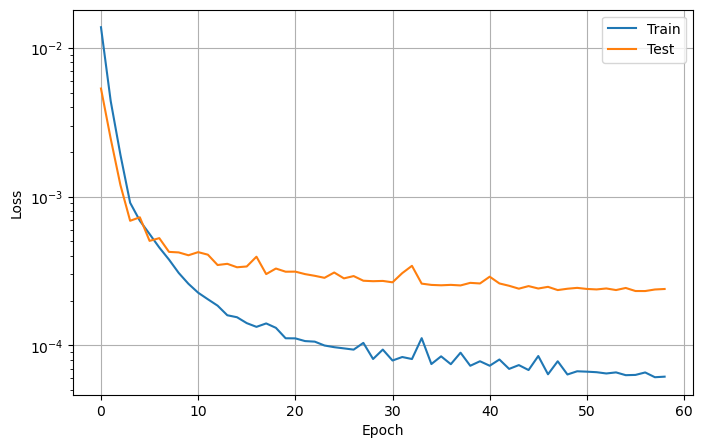

In [10]:
# Loss plot
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.yscale('log'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.show()

In [11]:
# epochs = range(1, len(train_losses) + 1)

# plt.figure(figsize=(8,5))
# plt.plot(epochs, train_losses, label='Train Loss')
# plt.plot(epochs, test_losses,  label='Test Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss Concentration')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()

# # SVG 파일로 저장
# plt.savefig("con_loss.svg", format="svg")

# # 필요하시다면 화면에도 출력
# plt.show()

In [12]:
# import matplotlib.pyplot as plt

# # 1) 도메인과 시점 리스트 정의
# domain_indices = [0, 200, 400]
# t_primes       = [0.0, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 0.28, 0.32, 0.36]
# selected_tps   = [0.04, 0.08, 0.12, 0.20]

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# # 2) 한 도메인 당 (2행 × len(selected_tps)열) 서브플롯 생성
# for d in domain_indices:
#     n_tp = len(selected_tps)
#     fig, axes = plt.subplots(
#         nrows=2, ncols=n_tp,
#         figsize=(n_tp*3, 2*3),
#         constrained_layout=True
#     )
    
#     for j, tp in enumerate(selected_tps):
#         # 전체 스택된 샘플에서의 인덱스 계산
#         j_all = t_primes.index(tp)
#         sample_idx = d * len(t_primes) + j_all
        
#         # 모델 예측 및 실제값 불러오기
#         sb = test_branch.to(device)[sample_idx:sample_idx+1]
#         st = test_trunk.to(device)[sample_idx:sample_idx+1]
#         with torch.no_grad():
#             pred = model(sb, st).cpu().numpy()[0]    # (64,148,1)
#         actual = test_tgt[sample_idx].numpy()       # (64,148,1)

#         # 역정규화 및 후보정
#         pred_dn  = inverse_normalize(pred, p_te[sample_idx])
#         actual_dn= inverse_normalize(actual, p_te[sample_idx])
#         mask     = test_branch[sample_idx,0].numpy()
#         pred_corr   = apply_candidate_correction(pred_dn,  mask)
#         actual_corr = apply_candidate_correction(actual_dn, mask)

#         # 첫째 행: 실제
#         ax = axes[0, j]
#         im = ax.imshow(actual_corr.squeeze(), origin='lower')
#         ax.set_title(f"Pred t'={tp/0.20:.1f}")
#         ax.axis('off')

#         # 둘째 행: 예측
#         ax = axes[1, j]
#         ax.imshow(pred_corr.squeeze(), vmin=im.get_clim()[0], vmax=im.get_clim()[1], origin='lower')
#         ax.set_title(f"Pred t'={tp/0.20:.1f}")
#         ax.axis('off')

#     fig.suptitle(f"Domain {d}", fontsize=16)
#     plt.savefig(f"domain_{d}.png")
#     plt.show()


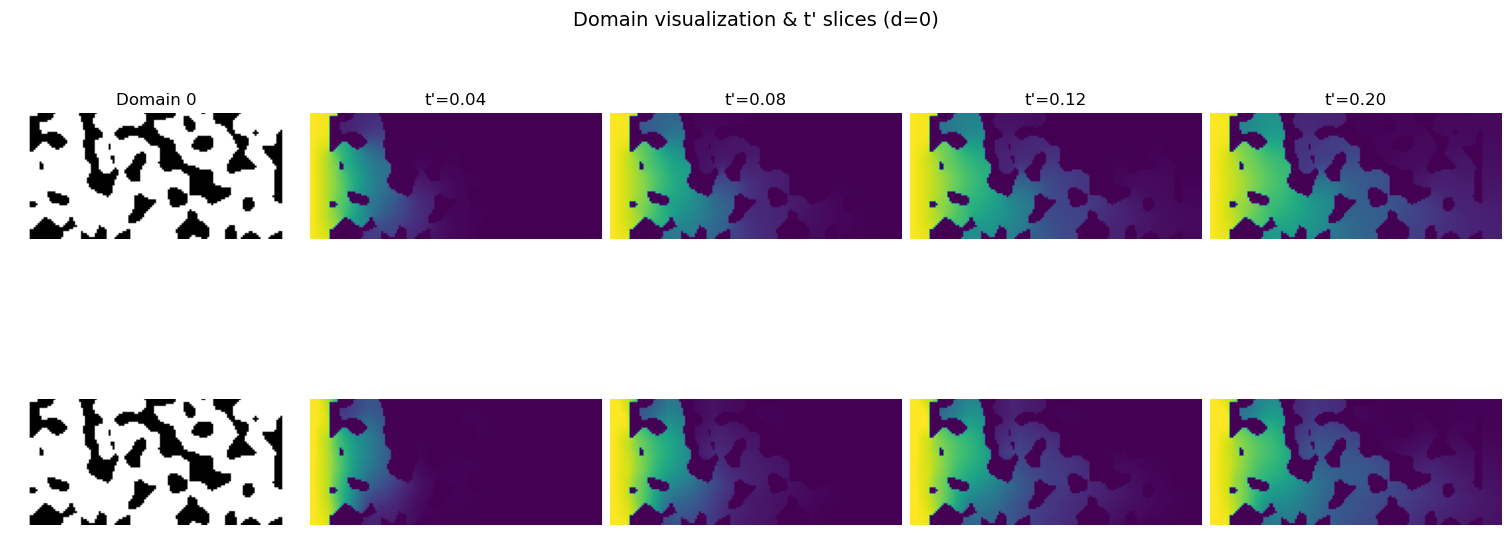

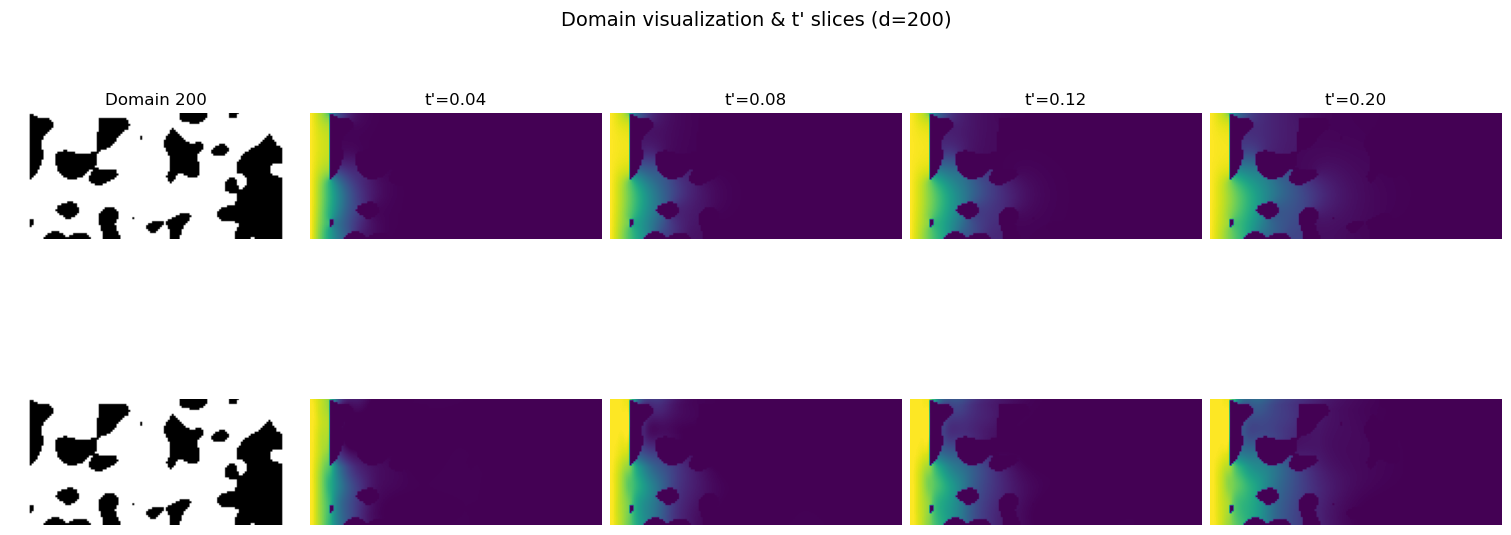

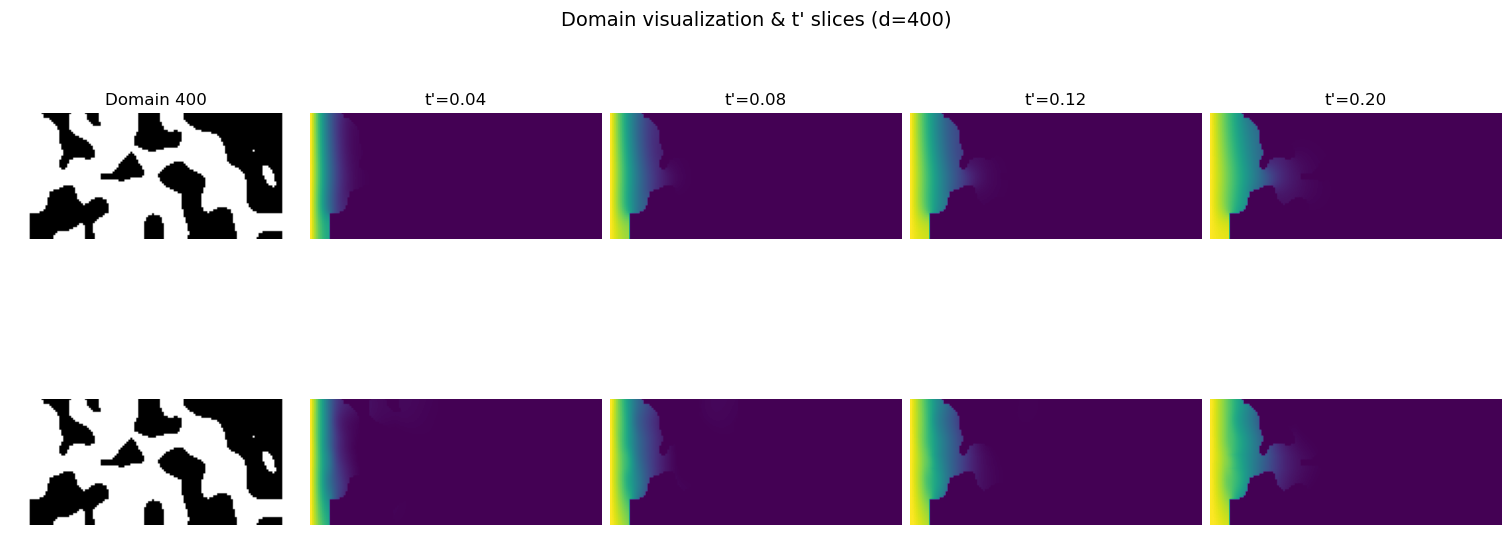

In [13]:
import matplotlib.pyplot as plt

# 1) 도메인과 시점 리스트 정의
domain_indices = [0, 200, 400]  # 원하는 도메인 index
t_primes       = [0.0, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 0.28, 0.32, 0.36]
selected_tps   = [0.04, 0.08, 0.12, 0.20]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

for d in domain_indices:
    n_tp = len(selected_tps) + 1  # +1: 맨 왼쪽에 도메인 이미지
    fig, axes = plt.subplots(
        nrows=2, ncols=n_tp,
        figsize=(n_tp * 3, 2 * 3),
        constrained_layout=True
    )

    # --- (가) 첫 열: 도메인 마스크 시각화 ---
    domain_mask = test_domains[d]['m']  # shape (64,148)
    for row in range(2):
        ax = axes[row, 0]
        ax.imshow(domain_mask, cmap='gray')
        if row == 0:
            ax.set_title(f"Domain {d}", fontsize=12)
        ax.axis('off')

    # --- (나) 나머지 열: t' 시점별 Actual / Predicted ---
    for j, tp in enumerate(selected_tps):
        col = j + 1  # 첫 열(0)은 도메인, 실제/예측은 1부터 시작

        # 전체 스택된 샘플에서의 인덱스 계산
        j_all = t_primes.index(tp)
        sample_idx = d * len(t_primes) + j_all

        # **2-Branch: 모델 예측**
        sb1 = test_b1.to(device)[sample_idx:sample_idx+1]
        sb2 = test_b2.to(device)[sample_idx:sample_idx+1]
        st  = test_trunk.to(device)[sample_idx:sample_idx+1]
        with torch.no_grad():
            pred = model(sb1, sb2, st).cpu().numpy()[0]    # (64,148,1)
        actual = test_tgt[sample_idx].numpy()              # (64,148,1)

        # 후보정 (정규화/역정규화 불필요)
        mask        = test_b1[sample_idx,0].numpy()
        pred_corr   = apply_candidate_correction(pred,  mask)
        actual_corr = apply_candidate_correction(actual, mask)

        # 행 0: 실제값
        ax0 = axes[0, col]
        im = ax0.imshow(actual_corr.squeeze())
        ax0.set_title(f"t'={tp:.2f}", fontsize=12)
        ax0.axis('off')

        # 행 1: 예측값
        ax1 = axes[1, col]
        ax1.imshow(pred_corr.squeeze(),
                   vmin=im.get_clim()[0],
                   vmax=im.get_clim()[1]
                   )
        ax1.axis('off')

    # 3) 저장 및 표시
    fig.suptitle(f"Domain visualization & t' slices (d={d})", fontsize=14)
    plt.savefig(f"time_pred_{d}.svg", dpi=150)
    plt.show()


In [14]:
# 0) base 도메인 번호 정의
base = 1317

# 1) test_domains에서 "원본 1317번"에 해당하는 sample 인덱스 찾기
def to_base(dnum):
    return ((dnum - 1) % 2000) + 1

domain_indices = [i for i, d in enumerate(test_domains)
                  if to_base(d['domain_num']) == base]

# 2) 공통 파라미터
t_primes     = [0.0, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 0.28, 0.32, 0.36]
selected_tps = [0.04, 0.08, 0.12, 0.20]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

for d in domain_indices:
    # orig_Da 계산
    orig_Da, _ = get_orig_and_norm_Da(test_domains[d]['domain_num'])
    da_val = int(orig_Da * 148)

    # 그리드 셋업: 2행 × (1+1+len(selected_tps))열
    n_imgs = len(selected_tps)
    n_cols = 1 + 1 + n_imgs    # Da 컬럼 + label 컬럼 + 이미지 컬럼
    fig = plt.figure(figsize=(n_cols*2.5, 2.5*2))
    gs = GridSpec(2, n_cols, figure=fig,
                  width_ratios=[0.5, 0.2] + [1]*n_imgs,
                  wspace=0.05, hspace=0.05)

    # --- 첫 열: Da 텍스트 (두 행 span) ---
    ax_da = fig.add_subplot(gs[:, 0])
    ax_da.axis('off')
    ax_da.text(0.5, 0.5,
               f"Da = {da_val}",
               ha='center', va='center',
               fontsize=16, fontweight='bold',
               transform=ax_da.transAxes)

    # --- 두 번째 열: (a) / (b) 레이블 ---
    ax_a = fig.add_subplot(gs[0, 1])
    ax_b = fig.add_subplot(gs[1, 1])
    for ax in (ax_a, ax_b):
        ax.axis('off')
    ax_a.text(0.5, 0.5, "(a)", ha='center', va='center',
              fontsize=14, fontweight='bold', transform=ax_a.transAxes)
    ax_b.text(0.5, 0.5, "(b)", ha='center', va='center',
              fontsize=14, fontweight='bold', transform=ax_b.transAxes)

    # --- 나머지 열: t' 시점별 Actual / Predicted ---
    shared_ax = None
    for j, tp in enumerate(selected_tps):
        idx_tp     = t_primes.index(tp)
        sample_idx = d * len(t_primes) + idx_tp

        # 실제 필드
        actual = test_tgt[sample_idx].numpy()           # (64,148,1)
        mask   = test_b1[sample_idx,0].numpy()          # (64,148)
        actual_corr = apply_candidate_correction(actual, mask)

        # 예측 필드 (2-branch)
        sb1 = test_b1.to(device)[sample_idx:sample_idx+1]
        sb2 = test_b2.to(device)[sample_idx:sample_idx+1]
        st  = test_trunk.to(device)[sample_idx:sample_idx+1]
        with torch.no_grad():
            pred = model(sb1, sb2, st).cpu().numpy()[0]  # (64,148,1)
        pred_corr = apply_candidate_correction(pred, mask)

        # Actual 히트맵 (row 0, col j+2)
        ax0 = fig.add_subplot(gs[0, j+2], sharex=shared_ax, sharey=shared_ax)
        im = ax0.imshow(actual_corr.squeeze(), cmap='viridis')
        ax0.set_title(f"t'={tp:.2f}", fontsize=12, pad=2)
        ax0.axis('off')

        # Predicted 히트맵 (row 1, col j+2)
        ax1 = fig.add_subplot(gs[1, j+2], sharex=ax0, sharey=ax0)
        ax1.imshow(pred_corr.squeeze(),
                   vmin=im.get_clim()[0],
                   vmax=im.get_clim()[1],
                   cmap='viridis')
        ax1.axis('off')

        if shared_ax is None:
            shared_ax = ax0

    # 전체 타이틀
    plt.savefig(f"time_{d}.svg", dpi=150, bbox_inches='tight')
    plt.show()


NameError: name 'GridSpec' is not defined

<Figure size 1500x500 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# t' 리스트 (process_concentration_domain와 동일하게 맞추세요)
t_primes     = [0.0, 0.04, 0.08, 0.12, 0.24, 0.36, 0.48, 0.60]
chunk_size   = 4
domain_indices = [1, 201, 401]  # 예시 도메인

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

for d in domain_indices:
    # 이 도메인의 8개 샘플 인덱스 범위
    base_idx = d * len(t_primes)
    
    # 4개씩 두 번 반복
    for chunk_start in range(0, len(t_primes), chunk_size):
        chunk_tps = t_primes[chunk_start:chunk_start+chunk_size]
        sample_indices = [base_idx + t_primes.index(tp) for tp in chunk_tps]
        
        # 2행×4열 figure
        fig, axes = plt.subplots(2, chunk_size,
                                 figsize=(chunk_size*3, 2*3),
                                 constrained_layout=True)
        
        for j, idx in enumerate(sample_indices):
            # (1) 예측 & 실제 불러오기
            sb1 = test_b1.to(device)[idx:idx+1]
            sb2 = test_b2.to(device)[idx:idx+1]
            st  = test_trunk.to(device)[idx:idx+1]
            with torch.no_grad():
                pred = model(sb1, sb2, st).cpu().numpy()[0]    # (64,148,1)
            actual = test_tgt[idx].cpu().numpy()              # (64,148,1)

            # (2) 후보정만 적용 (정규화/역정규화 X)
            mask     = test_b1[idx,0].cpu().numpy()
            pred_corr   = apply_candidate_correction(pred,  mask)
            actual_corr = apply_candidate_correction(actual, mask)
            
            # (3) MAPE/NRMSE
            mape, nrmse = compute_mape_nrmse_concentration_corrected(
                pred_corr, actual_corr, mask
            )
            
            # — 첫째 행: 산점도
            ax0 = axes[0, j]
            ax0.scatter(actual_corr.flatten(),
                        pred_corr.flatten(),
                        alpha=0.3, s=5)
            mn, mx = (min(actual_corr.min(), pred_corr.min()),
                      max(actual_corr.max(), pred_corr.max()))
            ax0.plot([mn, mx], [mn, mx], 'r--', lw=1)
            ax0.set_title(f"t'={chunk_tps[j]:.2f}")
            ax0.set_xticks([]); ax0.set_yticks([])
            ax0.text(0.05, 0.95,
                     f"MAPE={mape:.1f}%\nNRMSE={nrmse:.3f}",
                     transform=ax0.transAxes,
                     va='top', ha='left', fontsize=8,
                     bbox=dict(boxstyle="round,pad=0.2",
                               fc="white", alpha=0.7))
            
            # — 둘째 행: 절대 오차 히트맵
            ax1 = axes[1, j]
            abs_err = np.abs(pred_corr - actual_corr)
            vmin, vmax = 0, np.percentile(abs_err, 99)
            im = ax1.imshow(abs_err.squeeze(),
                            cmap='plasma',
                            vmin=vmin, vmax=vmax
                            )
            ax1.set_xticks([]); ax1.set_yticks([])
        
        # 컬러바 (두 번째 행 전체)
        cbar = fig.colorbar(im, ax=axes[1,:].tolist(),
                            orientation='vertical',
                            fraction=0.02, pad=0.01)
        cbar.set_label("Absolute Error")
        
        fig.suptitle(f"Domain {d} — t' indices {chunk_start}–{chunk_start+chunk_size-1}",
                     y=1.02)
        plt.show()


In [ ]:
torch.save(model.state_dict(), "con_steady_model_weights.pth")
torch.save(model, "con_steady_model_full.pth")


In [ ]:
from collections import defaultdict

# test_domains 에서 domain_num만 꺼내서 리스트로 만듭니다.
domain_nums = [d['domain_num'] for d in test_domains]

# base_id 계산: 1~2000 사이로 매핑
#   예: 1→1, …, 2000→2000, 2001→1, …, 4000→2000, 4001→1, …
def to_base(dnum):
    return ((dnum - 1) % 2000) + 1

# 같은 base_id 끼리 모으기
groups = defaultdict(list)
for dnum in domain_nums:
    b = to_base(dnum)
    groups[b].append(dnum)

# base_id 당 2개 이상 있는 것만 필터링
duplicates = {b: sorted(ids) for b, ids in groups.items() if len(ids) > 1}

# 결과 출력
for base_id, variants in duplicates.items():
    print(f"원본 도메인 {base_id}번: 시뮬레이션된 domain_num =", variants)


In [ ]:
import numpy as np

nrmse_list = []
num_samples = len(test_branch_tensor)  # 테스트 샘플 수

for idx in range(num_samples):
    # 1) 예측/실제값 역정규화 및 후보정
    preds_denorm, actual_denorm = evaluate_sample_concentration(
        model,
        test_branch_tensor,
        test_trunk_tensor,
        test_target_tensor,
        test_norm_params[idx],
        sample_idx=idx
    )
    # 2) 마스크 추출
    mask = test_branch_tensor[idx].cpu().numpy()[0]
    # 3) MAPE, NRMSE 계산 (후보정 적용)
    _, nrmse = compute_mape_nrmse_concentration_corrected(preds_denorm, actual_denorm, mask)
    nrmse_list.append(nrmse)

# 평균 NRMSE
average_nrmse = np.mean(nrmse_list)
print(f"Average NRMSE over {num_samples} test samples: {average_nrmse:.4f}")


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

num_samples = len(test_b1)  # (N,1,64,148)

# 1) 농도장 평균 비율 계산
conc_ratio = []
for idx in range(num_samples):
    # 예측·실제값 바로 가져오기
    sb1 = test_b1.to(device)[idx:idx+1]      # (1,1,64,148)
    sb2 = test_b2.to(device)[idx:idx+1]      # (1,1)
    st  = test_trunk.to(device)[idx:idx+1]   # (1,L,5)
    with torch.no_grad():
        preds = model(sb1, sb2, st).cpu().numpy()[0]
    actual = test_tgt[idx].cpu().numpy()
    mask = test_b1[idx, 0].cpu().numpy()

    # 후보정 및 평균
    preds_corr  = apply_candidate_correction(preds, mask)
    actual_corr = apply_candidate_correction(actual, mask)
    mean_pred   = preds_corr.mean()
    mean_actual = actual_corr.mean()

    conc_ratio.append(mean_actual / mean_pred if mean_pred != 0 else np.nan)

# 2) 시각화
plt.figure(figsize=(8,4))
plt.scatter(np.arange(num_samples), conc_ratio, alpha=0.5)
plt.hlines(1, 0, num_samples-1, linestyles='--', color='red', label='Ratio = 1')
plt.xlabel("Test Sample Index")
plt.ylabel("Actual / Predicted Mean Concentration")
plt.title("Mean Concentration Ratio per Test Sample")
plt.legend()
plt.tight_layout()
# plt.savefig("con_ratio.svg", format="svg")
plt.show()
